# Import library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
print([f for f in os.listdir("../data") if not f.startswith('.')])

Using TensorFlow backend.


['test_images', 'test.csv', 'train.csv', 'train_images', 'sample_submission.csv']


# Load data

In [6]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
dir_path='../data/'
train_img='train_images/'
test_img='test_images/'

In [3]:
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (3662, 2)
test shape: (1928, 1)


# EDA

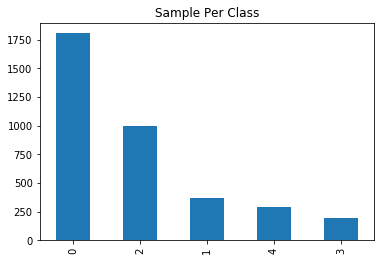

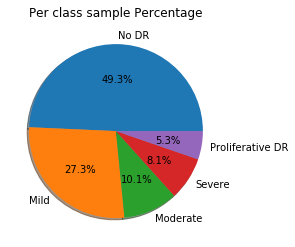

In [5]:
chat_data = train.diagnosis.value_counts()
chat_data.plot(kind='bar');
plt.title('Sample Per Class');
plt.show()
plt.pie(chat_data, autopct='%1.1f%%', shadow=True, labels=["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"])
plt.title('Per class sample Percentage');
plt.show()

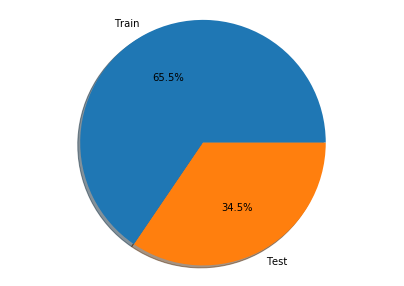

In [6]:
labels = 'Train', 'Test'
sizes = train.shape[0], test.shape[0]
colors = 'lightskyblue', 'lightcoral'
# Plot
plt.figure(figsize=(7, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.show()

# Visualize data

/Users/hankchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/Users/hankchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `item` has been deprecated and will be removed in a future version
  


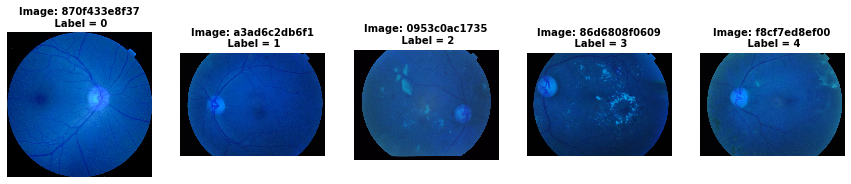

In [35]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train[train['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = cv2.imread(f"{dir_path+train_img}{image_name}.png")
    #X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    #X = cv2.resize(X, (512, 512))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [31]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    
    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image
    
    :return: A NumPy array containing the preprocessed image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (300, 300))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

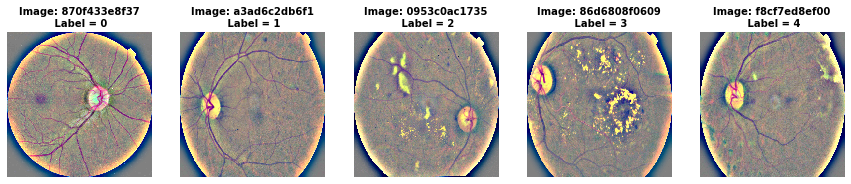

In [37]:
image_name=['870f433e8f37','a3ad6c2db6f1','0953c0ac1735','86d6808f0609','f8cf7ed8ef00']
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for a,b in enumerate(image_name):
    #sample = train[train['diagnosis'] == i].sample(1)
    #image_name = sample['id_code'].item()
    X = preprocess_image(cv2.imread(f"{dir_path+train_img}{b}.png"))
    ax[a].set_title(f"Image: {b}\n Label = {a}", weight='bold', fontsize=10)
    ax[a].axis('off')
    ax[a].imshow(X);

In [3]:
def draw_img(imgs, target_dir, class_label):
    fig, axis = plt.subplots(2, 6, figsize=(15, 6))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = os.path.join(dir_path, f"{target_dir}/{row['id_code']}.png")
        img = cv2.imread(imgPath)
        row = idnx // 6
        col = idnx % 6
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axis[row, col].imshow(img)
    plt.suptitle(class_label)
    plt.show()

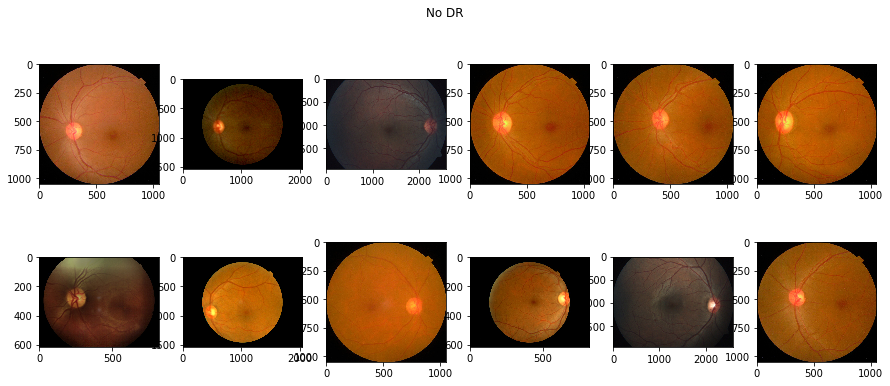

In [22]:
draw_img(train[train.diagnosis == 0].head(12), train_img, class_label='No DR')

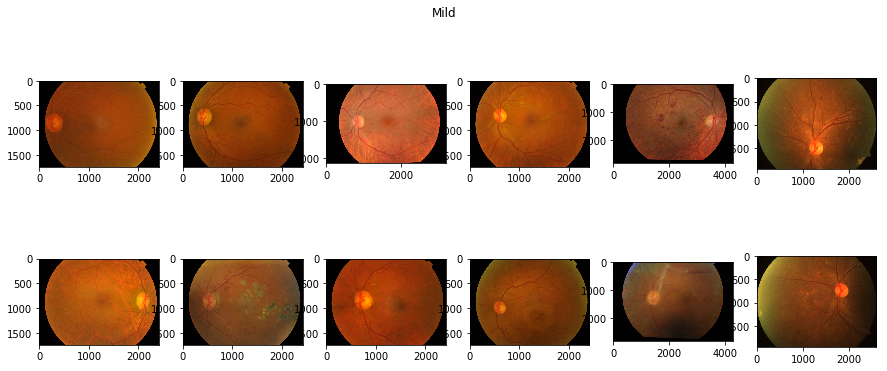

In [17]:
draw_img(train[train.diagnosis == 1].head(12), train_img, class_label='Mild')

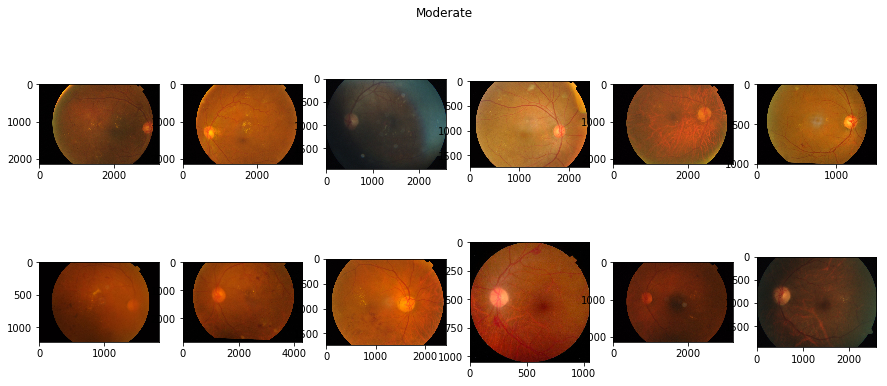

In [18]:
draw_img(train[train.diagnosis == 2].head(12), train_img, class_label='Moderate')

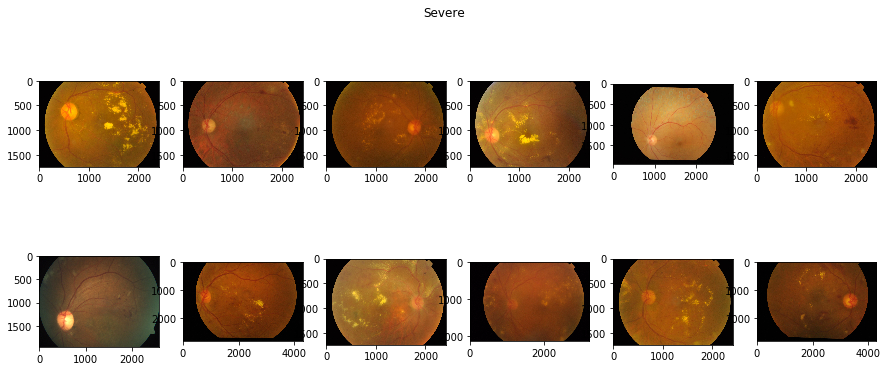

In [19]:
draw_img(train[train.diagnosis == 3].head(12), train_img, class_label='Severe')

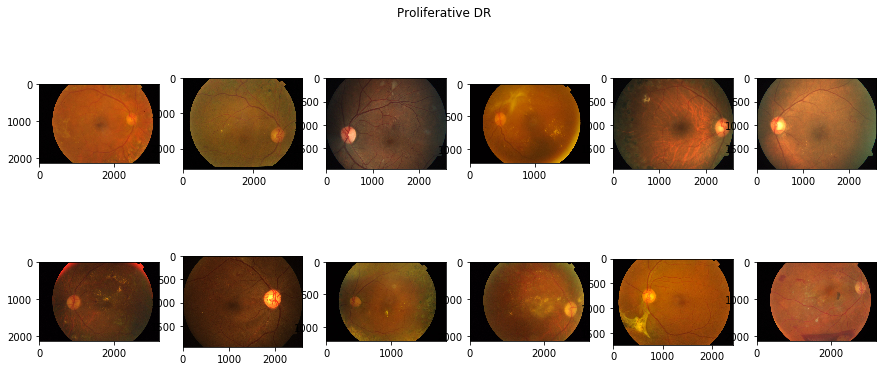

In [20]:
draw_img(train[train.diagnosis == 4].head(12), train_img, class_label='Proliferative DR')

# Model 1 - CNN(4 conv layers, 2 fc layers)

In [14]:
train.id_code = train.id_code.apply(lambda x: x + ".png")
test.id_code = test.id_code.apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')

In [115]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(150, 150, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(MaxPooling2D((3, 3)))

model.add(Conv2D(64, (2, 2), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(MaxPooling2D((3, 3)))

model.add(Conv2D(64, (2, 2), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))


model.add(MaxPooling2D((2, 2)))

#model.add(layers.Dropout(0.5))
model.add(Conv2D(64, (2, 2), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))


model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))

# model.add(MaxPooling2D((2, 2)))
          
model.add(Flatten())
          
model.add(layers.Dropout(0.5))
model.add(Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_119 (Bat (None, 150, 150, 32)      128       
_________________________________________________________________
activation_119 (Activation)  (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 50, 50, 64)        8256      
_________________________________________________________________
batch_normalization_120 (Bat (None, 50, 50, 64)        256       
_________________________________________________________________
activation_120 (Activation)  (None, 50, 50, 64)      

In [116]:
learning_rate = 1E-3 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [27]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                         validation_split=0.2,
                                         horizontal_flip=True,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         rotation_range=40, 
                                         zoom_range=0.15, 
                                         shear_range=0.15,
                                        fill_mode='nearest')


In [28]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory="../data/train_images/",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=20,
                                                    class_mode="categorical",
                                                    target_size=(150, 150),
                                                    subset='training',
                                                    shuffle=True)
                                                    
valid_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory="../data/train_images/",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=20,
                                                    class_mode="categorical",
                                                    target_size=(150, 150),
                                                    subset='validation',
                                                    shuffle=True)                                             

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [119]:
history = model.fit_generator(train_generator,\
                              steps_per_epoch=len(train)*0.8//20,\
                              epochs=20,\
                              validation_data=valid_generator,\
                             validation_steps=len(train)*0.2//20)                                  

Epoch 1/20
146/146 [==============================] - 596s 4s/step - loss: 1.1926 - acc: 0.5636 - val_loss: 3.5365 - val_acc: 0.3014
Epoch 2/20
146/146 [==============================] - 611s 4s/step - loss: 0.9947 - acc: 0.6509 - val_loss: 2.1269 - val_acc: 0.3048
Epoch 3/20
146/146 [==============================] - 607s 4s/step - loss: 0.9417 - acc: 0.6629 - val_loss: 1.1943 - val_acc: 0.4059
Epoch 4/20
146/146 [==============================] - 602s 4s/step - loss: 0.9028 - acc: 0.6773 - val_loss: 1.0162 - val_acc: 0.6685
Epoch 5/20
146/146 [==============================] - 603s 4s/step - loss: 0.8683 - acc: 0.6890 - val_loss: 1.3449 - val_acc: 0.5843
Epoch 6/20
146/146 [==============================] - 599s 4s/step - loss: 0.8438 - acc: 0.6911 - val_loss: 0.6943 - val_acc: 0.6671
Epoch 7/20
146/146 [==============================] - 595s 4s/step - loss: 0.8165 - acc: 0.7010 - val_loss: 0.8843 - val_acc: 0.7065
Epoch 8/20
146/146 [==============================] - 594s 4s/step - 

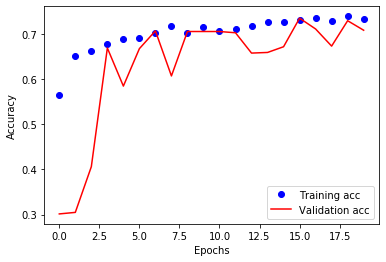

In [120]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()